<a href="https://colab.research.google.com/github/GeoTurkey/Jupyter_Binder/blob/master/Airline_Passengers_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from torch.autograd import Variable

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
df = pd.read_csv('airline-passengers.csv', index_col="Month", parse_dates=True)


fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size



all_data = df['Passengers'].values.astype(float)


test_data_size = 48

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 24
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)



--2020-11-10 19:32:26--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2020-11-10 19:32:26 (42.3 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
epochs = 900

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)
epoch:   1 loss: 0.02643649
epoch:  26 loss: 0.00036218
epoch:  51 loss: 0.00148930
epoch:  76 loss: 0.00024091
epoch: 101 loss: 0.00017483
epoch: 126 loss: 0.00065150
epoch: 151 loss: 0.00009057
epoch: 176 loss: 0.00000192
epoch: 201 loss: 0.00008623
epoch: 226 loss: 0.00502097
epoch: 251 loss: 0.00323850
epoch: 276 loss: 0.00103384
epoch: 301 loss: 0.00027567
epoch: 326 loss: 0.00305865
epoch: 351 loss: 0.00007763
epoch: 376 loss: 0.00007865
epoch: 401 loss: 0.00021988
epoch: 426 loss: 0.00012816
epoch: 451 loss: 0.00020734
epoch: 476 loss: 0.00002824
epoch: 501 loss: 0.00009541
epoch: 526 loss: 0.00001752
epoch: 551 loss: 0.00000591
epoch: 576 loss: 0.00006721
epoch: 601 loss: 0.00054703
epoch: 626 loss: 0.00004564
epoch: 651 loss: 0.00002854
epoch: 676 loss: 0.00008141
epoch: 701 loss: 0.00000080
epoch: 726 loss: 0.00001033
epoch: 751 loss: 0.00502375
epoch: 776 loss: 0.00000038
epoch: 801

### MAKING PREDICTIONS

```
# This is formatted as code
```



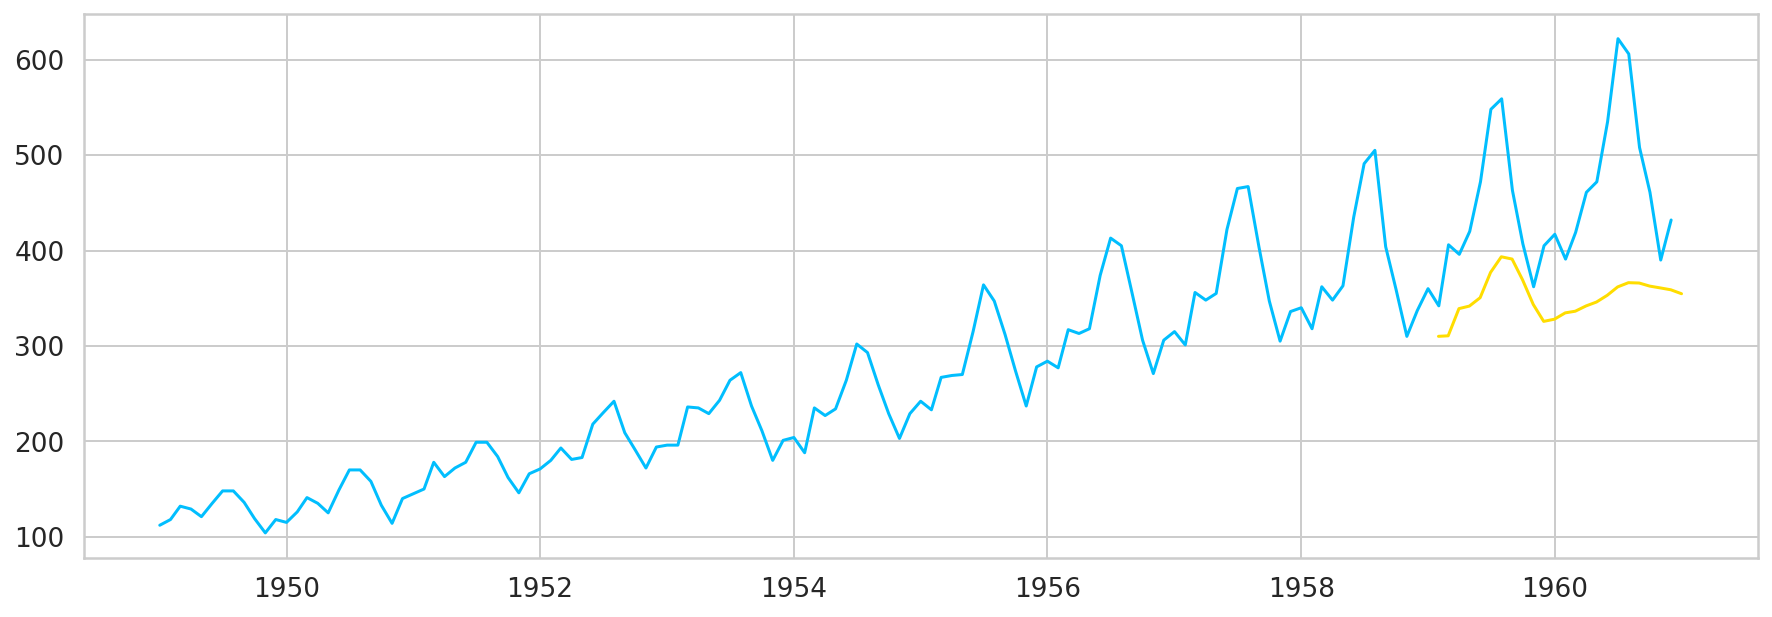

In [8]:
fut_pred = 24

test_inputs = train_data_normalized[-train_window:].tolist()


model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

#actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1).flatten())

actual_predictions = scaler.inverse_transform(
  np.expand_dims(test_inputs[train_window:], axis=0)
).flatten()

future_index = pd.date_range(
  start=df[-train_window:].index[0],
  periods=24,freq = "M",
  closed='right'
)
forecasted_passengers = pd.Series(
  data=actual_predictions,
  index=future_index
)

df2=pd.DataFrame(data=forecasted_passengers, columns=["actual_predictions"])
plt.plot(df["Passengers"], label='Original');
plt.plot(df2["actual_predictions"], label="Predicted");

In [12]:
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

device(type='cpu')

In [38]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Timestamp('1959-12-01 00:00:00')

In [ ]:
to_device(model, device)
